In [1]:
# Import the modules
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scop
import scipy.integrate as scin
import string
import matplotlib.animation as animation

# Latex printing
sp.init_printing(use_latex = True)

# pCCM coordinates

In [2]:
# Define the spacetime and collective coordinates
x = sp.Symbol('x')
a = sp.Symbol('a')
C = sp.Symbol('C')

coords = [a, C]
Ncoords = len(coords)

coords

# KAK configuration

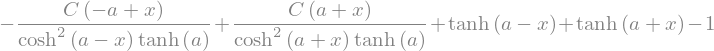

In [3]:
# Define the pCCM kink-antikink configuration with one expanded coefficient
phiKAK = sp.tanh(x+a) + C/sp.tanh(a)*(x+a)/sp.cosh(x+a)**2 - sp.tanh(x-a) - C/sp.tanh(a)*(x-a)/sp.cosh(x-a)**2 - 1

phiKAK

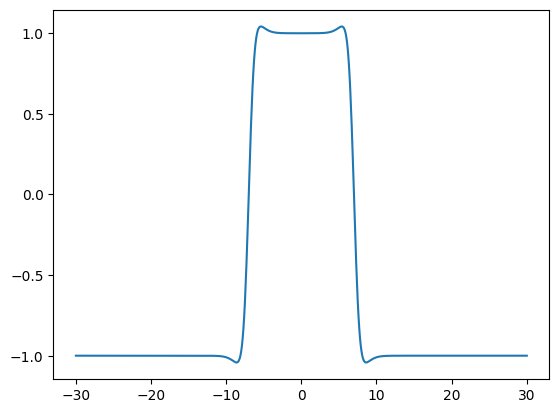

In [4]:
# Plot the configuration
phiKAK_init = sp.lambdify((x,a,C), phiKAK)

# Space grid
dx = 0.1
xmax = 30
xr = np.arange(-xmax, xmax+dx, dx)
N = len(xr)

plt.plot(xr, phiKAK_init(xr, 7, 0.5))
plt.show()

# Potential
## $V = \frac{1}{2}(1 - \phi^2)^2$

In [5]:
Upot = sp.expand(0.5*(1-phiKAK**2)**2)

# Setup the pCCM model

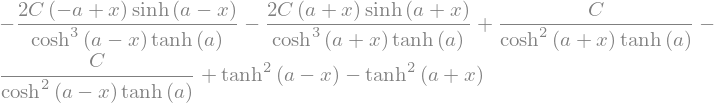

In [6]:
# Derivatives of the field with respect to the coordinates
dphi_dx = sp.diff(phiKAK, x)

dphi = []
d2phi = []
for i in range(Ncoords):
    dphi.append(sp.diff(phiKAK, coords[i]))
    d2phi.append([])
    for j in range(Ncoords):
        d2phi[i].append(sp.diff(dphi[i], coords[j]))

dphi_dx

In [7]:
# Define the CCM potential
Vpot = 0.5*dphi_dx**2 + Upot

# Derivative of the CCM potential with respect to the coordinates
dVpot = []
for i in range(Ncoords):
    dVpot.append(sp.diff(Vpot, coords[i]))

## Define all the terms that appear in the Euler-Lagrange equations

In [9]:
# Derivatives of the coordinates
da = sp.Symbol(r'\dot{a}')
dC = sp.Symbol(r'\dot{C}')
d2a = sp.Symbol(r'\ddot{a}')
d2C = sp.Symbol(r'\ddot{C}')

dcoords = [da, dC]
d2coords = [d2a, d2C]

# Coefficients to integrate: H^{a}_{bc}, E_{ab}, W_{a}
H = []
E = []
W = []

for i in range(Ncoords):
    W.append(sp.Symbol('W_{'+string.ascii_lowercase[i]+'}'))
    H.append([])
    E.append([])
    for j in range(Ncoords):
        E[i].append(sp.Symbol('E_{'+string.ascii_lowercase[i]+string.ascii_lowercase[j]+'}'))
        H[i].append([])
        for k in range(Ncoords):
            H[i][j].append(sp.Symbol('H^{'+string.ascii_lowercase[i]+'}_{'+string.ascii_lowercase[j]+string.ascii_lowercase[k]+'}'))

# Apply the symmetry properties
for i in range(Ncoords):
    for j in range(i+1):
        E[i][j] = E[j][i]
        for k in range(Ncoords):
            H[k][i][j] = H[k][j][i]

E

# Euler-Lagrange equations

In [10]:
Eq1 = W[0]
Eq2 = W[1]
for i in range(Ncoords):
    Eq1 += d2coords[i]*E[0][i]
    Eq2 += d2coords[i]*E[1][i]
    for j in range(Ncoords):
        Eq1 += dcoords[i]*dcoords[j]*H[0][i][j]
        Eq2 += dcoords[i]*dcoords[j]*H[1][i][j]

Eq1

In [11]:
Eq2

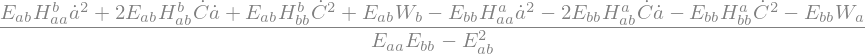

In [12]:
# Decouple the equations
ddC = sp.simplify(sp.solve(Eq1, d2C)[0])

Eqa = sp.solve(sp.simplify(Eq2.subs(d2C, ddC)), d2a)[0]
Eqa

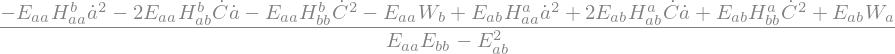

In [13]:
EqC = sp.simplify(ddC.subs(d2a, Eqa))

EqC

In [14]:
# Create the tensors
H_vals = []
E_vals = []
W_vals = []

for i in range(Ncoords):
    W_vals.append(dVpot[i])
    E_vals.append([])
    H_vals.append([])
    for j in range(Ncoords):
        E_vals[i].append(dphi[i]*dphi[j])
        H_vals[i].append([])
        for k in range(Ncoords):
            H_vals[i][j].append(dphi[i]*d2phi[j][k])

In [15]:
# Lambdify the expressions
H_values = []
E_values = []
W_values = []

for i in range(Ncoords):
    W_values.append(sp.lambdify((x,a,C), W_vals[i], 'numpy'))
    E_values.append([])
    H_values.append([])
    for j in range(Ncoords):
        E_values[i].append(sp.lambdify((x,a,C), E_vals[i][j], 'numpy'))
        H_values[i].append([])
        for k in range(Ncoords):
            H_values[i][j].append(sp.lambdify((x,a,C), H_vals[i][j][k], 'numpy'))

Value of the Integral =  -3.6838660006747336e-06


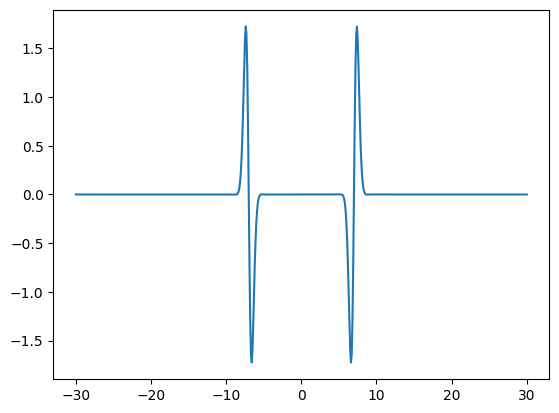

In [18]:
# Test one
Tx = H_values[0][0][0](xr, 7, 0.5)

integral = scin.trapezoid(Tx, xr)

plt.plot(xr, Tx)
print('Value of the Integral = ', integral)
plt.show()

# Energy function of the system

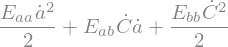

In [19]:
# E = T + V
Vpot_values = sp.lambdify((x,a,C), Vpot)

Kinet = 0
for i in range(Ncoords):
    for j in range(Ncoords):
        Kinet += E[i][j]*dcoords[i]*dcoords[j]/2

Kinet

In [20]:
def Energy(varies):
    Nl = len(varies[0])
    Enes = np.zeros(Nl)
    
    a_val, C_val, da_val, dC_val = varies
    
    E_integrated = np.zeros((Ncoords,Ncoords))
    for iters in range(Nl):    
        En = scin.trapezoid(Vpot_values(xr, a_val[iters], C_val[iters]), xr)
        Kinet_values = Kinet.subs(da, da_val[iters]).subs(dC, dC_val[iters])
        
        for i in range(Ncoords):
            for j in range(i+1):
                E_arr = E_values[i][j](xr, a_val[iters], C_val[iters])
                E_integrated[i,j] = scin.trapezoid(E_arr, xr)
                Kinet_values = Kinet_values.subs(E[i][j], E_integrated[i,j])

        En += Kinet_values
        Enes[iters] = En
    return Enes

In [21]:
def EL(t, varies):
    print('t = ', t)
    a_val, C_val, da_val, dC_val = varies
    
    H_integrated = np.zeros((Ncoords,Ncoords,Ncoords))
    E_integrated = np.zeros((Ncoords,Ncoords))
    W_integrated = np.zeros(Ncoords)

    # Integrate in x and substitute in the EL eqs
    Eqdda = 1.0*Eqa
    EqddC = 1.0*EqC
    for i in range(Ncoords):
        W_arr = W_values[i](xr, a_val, C_val)
        W_integrated[i] = scin.trapezoid(W_arr, xr)
        Eqdda = Eqdda.subs(W[i], W_integrated[i])
        EqddC = EqddC.subs(W[i], W_integrated[i])
        for j in range(i+1):
            E_arr = E_values[i][j](xr, a_val, C_val)
            E_integrated[i,j] = scin.trapezoid(E_arr, xr)
            Eqdda = Eqdda.subs(E[i][j], E_integrated[i,j])
            EqddC = EqddC.subs(E[i][j], E_integrated[i,j])
            for k in range(Ncoords):
                H_arr = np.ones(N)*H_values[k][i][j](xr, a_val, C_val) # This is because H^0_{11} = 0
                H_integrated[k,i,j] = scin.trapezoid(H_arr, xr)
                Eqdda = Eqdda.subs(H[k][i][j], H_integrated[k,i,j])
                EqddC = EqddC.subs(H[k][i][j], H_integrated[k,i,j])
    
    dadt = da_val
    dCdt = dC_val
    dda = Eqdda.subs(da, da_val).subs(dC, dC_val)
    ddC = EqddC.subs(da, da_val).subs(dC, dC_val)
    
    return np.array([dadt, dCdt, dda, ddC])

In [22]:
# Initial conditions
a0 = 6
v = -0.25
C0 = 0.5*v**2 + 0.210507*v**4 + 0.027428*v**6 - 0.0302351*v**8 # This may be obtained using a shooting method for ddC = 0

vinic = np.array([a0, C0, v, 0])

# Time grid
dt = 0.01
tmax = abs(3*a0/v)
t = np.arange(0.0, tmax, dt)

In [24]:
# Solve the system for a single velocity
sol = scin.solve_ivp(EL, (t[0], t[-1]), vinic, method = 'RK45', t_eval = t, rtol = 1e-7, atol = 1e-7)

t =  0.0
t =  0.24660036270739544
t =  0.004473707658218198
t =  0.006710561487327296
t =  0.017894830632872793
t =  0.019883145147636432
t =  0.02236853829109099
t =  0.02236853829109099
t =  0.06710561487327298
t =  0.08947415316436395
t =  0.2013168446198189
t =  0.2211999897674553
t =  0.24605392120200087
t =  0.24605392120200087
t =  0.44683045742995664
t =  0.5472187255439345
t =  1.0491600661138238
t =  1.1383940822151375
t =  1.2499366023417795
t =  1.2499366023417795
t =  1.4495951345029134
t =  1.5494244005834805
t =  2.0485707309863157
t =  2.137307856391264
t =  2.2482292631474494
t =  2.2482292631474494
t =  2.4678274870183636
t =  2.577626598953821
t =  3.126622158631107
t =  3.2242213692404023
t =  3.3462203825020214
t =  3.3462203825020214
t =  3.544496275903067
t =  3.64363422260359
t =  4.139323956106204
t =  4.2274465753955575
t =  4.337599849507249
t =  4.337599849507249
t =  4.53928506852278
t =  4.640127678030546
t =  5.144340725569373
t =  5.2339786006873865
t = 

# Check the conservation of the energy

In [25]:
array_Energies = Energy(sol.y)
print('Error (%) = ', 100*(np.max(array_Energies)-np.min(array_Energies))/np.min(array_Energies))

Error (%) =  1.764331363079572e-05


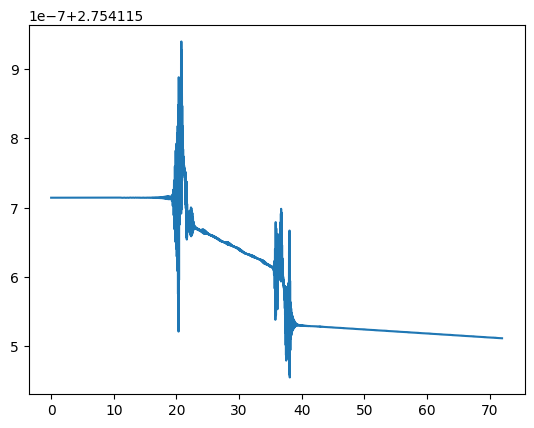

In [26]:
# Show the conservation of the energy
plt.plot(sol.t, array_Energies)
plt.show()

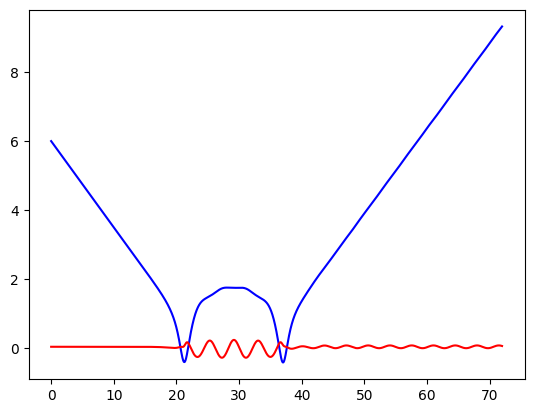

In [27]:
plt.plot(sol.t, sol.y[0], 'b-')
plt.plot(sol.t, sol.y[1], 'r-')
plt.show()

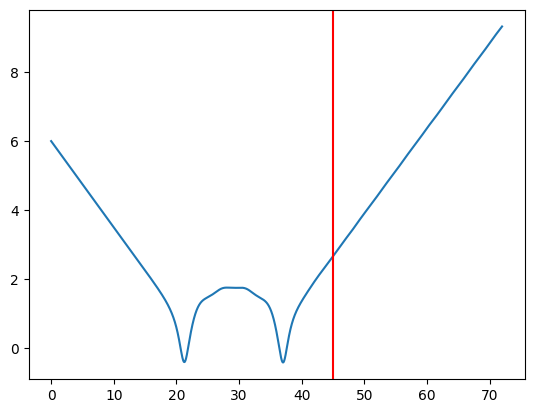

In [28]:
# Check to obtain the outgoing velocity
plt.plot(sol.t, sol.y[0])
plt.axvline(45, color = 'red')
plt.show()

# Calculate the outgoing velocity

In [30]:
def final_v(t, m, n):
    return m*t + n

tmin = 45
idx_min = np.where(sol.t >= tmin)[0][0]
idx_max = np.where(sol.t <= tmax)[0][-1]

# Using curve fit
v_out = scop.curve_fit(final_v, sol.t[idx_min:idx_max], sol.y[0][idx_min:idx_max])[0][0]
# Calculate the mean value of \dot{a}
v_out2 = np.sum(sol.y[2][idx_min:idx_max])/len(sol.y[2][idx_min:idx_max])

print('v_out = ', np.round(v_out, 5), np.round(v_out2, 5))

v_out =  0.24705 0.24704


# Animate the solution

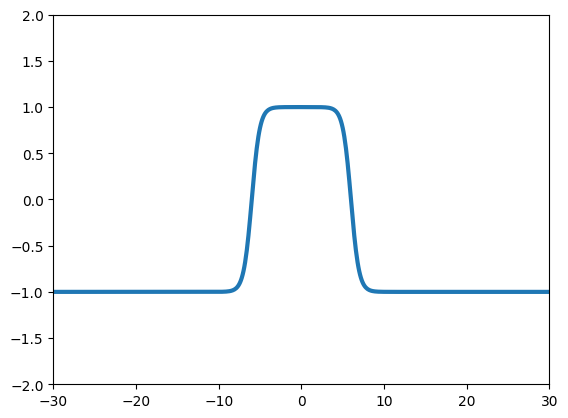

In [34]:
fig = plt.figure()
ax = plt.axes(xlim = (-xmax, xmax), ylim = (-2, 2))

line, = ax.plot([], [], lw = 3)
def update(i):
    x = xr
    y = phiKAK_init(xr, sol.y[0][i], sol.y[1][i])
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, update, frames = len(sol.t), interval = dt, blit=True)

#anim.save('CCM_phi4.gif', writer = 'pillow')
plt.show()